# Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, precision_recall_fscore_support, accuracy_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures

# Importing dataset 

In [2]:
std_df = pd.read_csv('processed_dataset/std_dataset.csv', index_col = 0)
std_df.shape

(36733, 39)

In [3]:
dev_df = std_df.loc[:24487,:]
dev_df.shape

(24488, 39)

In [4]:
eval_df = std_df.loc[24488:, :]
eval_df.shape

(12245, 39)

In [5]:
ambiental_pred = ['AT', 'AP', 'AH']
process_pred = ['AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
location_pred = ['Austria', 'Belgium', 'Bulgaria', 'Croatia',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal',
       'Republic of Cyprus', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden']
nox = ['NOX']
year = ['YEAR']

In [6]:
features_lists = [
    'all',
    ambiental_pred,
    process_pred,
    ambiental_pred+nox,
    ambiental_pred+year,
    ambiental_pred+nox+year,
    process_pred+nox,
    process_pred+year,
    process_pred+nox+year,
    ambiental_pred+process_pred,
    ambiental_pred+process_pred+nox,
    ambiental_pred+process_pred+year,
    ambiental_pred+process_pred+nox+year,
]

# Model building 

In [28]:
class Model():
    
    def __init__(self, model_classifier, standard_regressor, extreme_regressor):
        
        self.classifier = model_classifier
        self.std_regr = standard_regressor
        self.ext_regr = extreme_regressor
        self.std_columns = 'all'
        self.ext_columns = 'all'
        
        
    def fit(self, X, co_values, binary_labels, std_columns = 'all', ext_columns = 'all'):
        
        print('Fitting the classifier.....')
        self.classifier.fit(X,binary_labels)
        print('Classifier fitted')
        
        mask = binary_labels.values == 0
        
        if std_columns == 'all':
            std_X, std_co_values = X.loc[mask,:], co_values.loc[mask]
        else:
            self.std_columns = std_columns
            std_X, std_co_values = X.loc[mask,std_columns], co_values.loc[mask]
            
            
        if ext_columns == 'all':
            ext_X, ext_co_values = X.loc[~mask,:], co_values.loc[~mask]
        else:
            ext_X, ext_co_values = X.loc[~mask,ext_columns], co_values.loc[~mask]
            self.ext_columns = ext_columns
        
        print(std_X.shape, ext_X.shape)
        
        print('Fitting the standard regressor...')
        self.std_regr.fit(std_X, std_co_values)
        print('Standard Regressor fitted')
        print('Fitting the extreme regressor...')
        self.ext_regr.fit(ext_X, ext_co_values)
        print('Extrem Regressor fitted')
        
        return True
    
    def predict(self,X,labels):
        
        pred_labels = self.classifier.predict(X)
        
        mask = pred_labels == 0
        #mask = labels.values == 0
        
        if self.std_columns == 'all':
            std_X = X.loc[mask,:]
        else:
            std_X = X.loc[mask,self.std_columns]
          
        if self.ext_columns == 'all':
            ext_X = X.loc[~mask,:]
        else:
            ext_X = X.loc[~mask,self.ext_columns]
        
        
        print(type(self.std_columns))
        std_pred = self.std_regr.predict(std_X)
        ext_pred = self.ext_regr.predict(ext_X)
        
        y_pred = np.zeros(shape = pred_labels.shape)
        y_pred[mask] = std_pred
        y_pred[~mask] = ext_pred
        
        return y_pred, pred_labels
        
        

### Dataset preparation

In [32]:
dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 5.38 else 1)
dev_df[['CO','labels']]

/tmp/ipykernel_35357/3577560697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 5.38 else 1)


,CO,labels
ID,,
0,1.07640,0
1,10.19600,1
2,0.78407,0
3,1.61530,0
4,1.40710,0
...,...,...
24483,1.60010,0
24484,2.21050,0
24485,2.00960,0


In [33]:
dev_df['CO'].loc[dev_df['CO'] < 5.38,].count()

22803

In [34]:
dev_df['labels'].value_counts()

0    22803
1     1685
Name: labels, dtype: int64

In [35]:
X = dev_df[ambiental_pred+process_pred+nox+year]
co_values = dev_df['CO']
labels = dev_df['labels']



poly = PolynomialFeatures(degree = 3)
X = poly.fit_transform(X.drop(columns= ['TEY', 'CDP']))
X = pd.DataFrame(X, columns = poly.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X, pd.DataFrame({'CO': co_values, 'labels':labels}),
                                                    random_state=42, test_size=0.25,
                                                    stratify=dev_df['labels'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((18366, 220), (6122, 220), (18366, 2), (6122, 2))

### Random Forest

In [36]:
clf = RandomForestClassifier(n_estimators= 400, min_samples_split=2, min_samples_leaf=1, 
                             max_features= 'log2', max_depth = 110,
                             random_state=42)

std_regr = RandomForestRegressor(n_estimators=300, min_samples_split=4, 
                                 min_samples_leaf=2, max_features='sqrt',
                                 max_depth=20, bootstrap = False, 
                                 random_state = 42)

ext_regr = RandomForestRegressor(random_state = 42, 
                                 n_estimators = 300, 
                                 min_samples_split=4, min_samples_leaf = 1, 
                                 max_features='sqrt',
                                 max_depth=60,
                                 bootstrap=False)

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)


model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Fitting the classifier.....
Classifier fitted
(17102, 220) (1264, 220)
Fitting the standard regressor...
Standard Regressor fitted
Fitting the extreme regressor...
Extrem Regressor fitted


True

In [37]:
y_pred, pred_labels = model.predict(X_test, y_test['labels'])

<class 'str'>


In [38]:
mse(y_test['CO'].values, y_pred)

1.6923058232307087

In [122]:
sorted(zip(model.std_regr.feature_names_in_, model.std_regr.feature_importances_), key = lambda x : x[1], reverse = True)

[('TIT', 0.5263653908976524),
 ('YEAR', 0.13635108555758907),
 ('TEY', 0.11871023323828069),
 ('AT', 0.11259982828924023),
 ('NOX', 0.1059734620172376)]

In [123]:
sorted(zip(model.ext_regr.feature_names_in_, model.ext_regr.feature_importances_), key = lambda x : x[1], reverse = True)

[('TAT', 0.5460966523167575),
 ('TIT', 0.14143824373207087),
 ('NOX', 0.1102080586308961),
 ('GTEP', 0.10966403581271976),
 ('CDP', 0.09259300950755583)]

In [124]:
sorted(zip(model.classifier.feature_names_in_, model.classifier.feature_importances_), key = lambda x : x[1], reverse = True)

[('TIT', 0.19146776861870676),
 ('CDP', 0.17448398007655463),
 ('TEY', 0.12764619009635794),
 ('GTEP', 0.10294689319627162),
 ('AFDP', 0.09795872163393265),
 ('NOX', 0.07938146780143301),
 ('TAT', 0.059219959323953),
 ('AT', 0.05233942519130438),
 ('AH', 0.04384871168280635),
 ('YEAR', 0.03572982577402099),
 ('AP', 0.03497705660465879)]

In [25]:
precision_recall_fscore_support(y_test['labels'], pred_labels)

(array([0.97439649, 0.87003058]),
 array([0.98429706, 0.80253879]),
 array([0.97932175, 0.83492296]),
 array([5413,  709]))

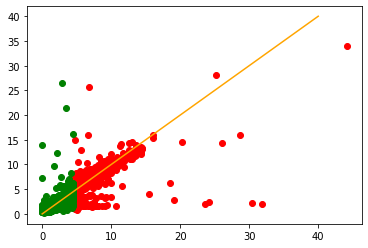

In [26]:
plt.scatter(y_test['CO'].loc[y_test['labels'] == 1].values, y_pred[y_test['labels'] == 1], c = 'red')
plt.scatter(y_test['CO'].loc[y_test['labels'] == 0].values, y_pred[y_test['labels'] == 0], c = 'green')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'orange')

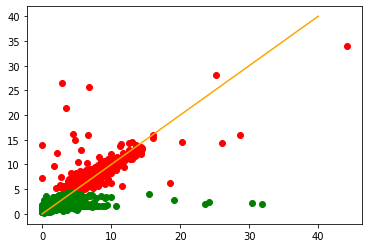

In [28]:
plt.scatter(y_test['CO'].loc[pred_labels == 1].values, y_pred[pred_labels == 1], c = 'red')
plt.scatter(y_test['CO'].loc[pred_labels == 0].values, y_pred[pred_labels == 0], c = 'green')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'orange')

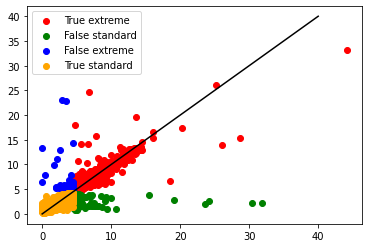

In [26]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

In [27]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5328,   85],
       [ 140,  569]])

### SVM classifier

In [68]:
clf = SVC(random_state=42)
std_regr = RandomForestRegressor(random_state = 42)
ext_regr = RandomForestRegressor(random_state = 42)

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)
model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Classifier fitted
(16239, 37) (2127, 37)
Standard Regressor fitted
Extrem Regressor fitted


True

In [69]:
y_pred, pred_labels = model.predict(X_test, y_test['labels'])

In [73]:
mse(y_test['CO'].values, y_pred)

1.4861789733783997

In [74]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5317,   96],
       [ 192,  517]])

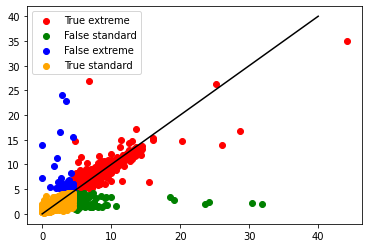

In [75]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

### MLP Classifier

In [134]:
clf = MLPClassifier(random_state=42, max_iter = 10000)
std_regr = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_features=None,
                                 max_depth=30, bootstrap=True, 
                                 random_state = 42)

ext_regr = RandomForestRegressor(random_state = 42, n_estimators = 500, 
                                 min_samples_split=2, min_samples_leaf = 1, 
                                 max_features='sqrt')

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)
model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Classifier fitted
(16239, 11) (2127, 11)
Standard Regressor fitted
Extrem Regressor fitted


True

In [135]:
y_pred, pred_labels = model.predict(X_test, y_test['labels'])

<class 'str'>


In [136]:
mse(y_test['CO'].values, y_pred)

1.3527174273452256

In [137]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5314,   99],
       [ 146,  563]])

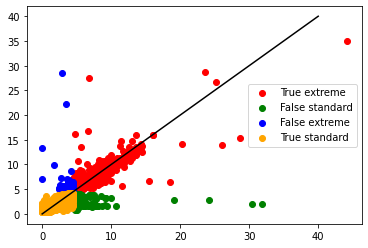

In [133]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

# Ensemble method

In [27]:
dev_df['AT'].mean()

3.847515793931284e-16

In [16]:
Xy = dev_df.loc[:,:'CO']
Xy['labels'] = Xy['CO'].apply(lambda x : 0 if x <=4.5 else 1)

ix = pd.IndexSlice

grouped = Xy.groupby('labels').describe().loc[slice(None),ix[:,['mean','std']]]
grouped.loc[0].loc[ix[:,'mean']]

YEAR    3.056897
AT      0.055846
AP     -0.006081
AH     -0.053063
AFDP    0.138883
GTEP    0.165964
TIT     0.222274
TAT    -0.011829
TEY     0.180834
CDP     0.174814
NOX    -0.113742
CO      1.777638
Name: 0, dtype: float64

In [144]:
class Classifier():
    
    def __init__(self, n_features = 3, threshold = 0.5):
        self.n_features = n_features
        self.threshold = threshold
        self.ix = pd.IndexSlice
        
        
    def fit(self, X):
        self.features = list(X.loc[:,:'NOX'].sample(n=self.n_features, axis = 1).columns)
        self.mean_std = X.groupby(by= 'labels').describe().loc[slice(None),self.ix[self.features,['mean','std']]]
        
    def predict(self, X):
        result = X[self.features].copy()
        for col in self.features:
            result[col] = result[col].apply(lambda x : labeling(x, self.mean_std[col]))
        result = (result.sum(axis = 1)/len(result.loc[:'NOX'].columns)).apply(lambda x : 0 if x<self.threshold else 1)
        return result.values
        
    def labeling(self, x, mean_std_col):
        mean,std = mean_std_col.loc[1].values
        label = 0
        lower = mean-std
        upper = mean+std
        if lower <= x <= upper:
            label = 1
        return label
    

class EnsembleClassifier():
    
    def __init__(self, n_estimators = 100, n_features_per_estimator = 3, threshold = 0.5):
        self.n_estimators = n_estimators
        self.n_features_per_estimator = n_features_per_estimator
        self.threshold = threshold
        self.estimators = [Classifier(n_features = n_features_per_estimator ,threshold = threshold) for i in range(n_estimators)]
        
    def fit(self, X):
        for est in self.estimators:
            est.fit(X)
        
    def predict(self, X):
        
        predictions = np.array([est.predict(X) for est in self.estimators])
        print(predictions)
        predictions = (predictions.sum(axis = 0) / self.n_estimators)
        print(predictions)
        predictions = np.array(list(map(lambda x : 0 if x<self.threshold else 1, predictions)))
        
        return predictions
    
        

In [126]:
clf = Classifier()
clf.fit(Xy)

pred = clf.predict(Xy.loc[:20,:'NOX'])

print(np.array(pred))    

[0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0]


In [150]:
en_clf = EnsembleClassifier(n_estimators = 10, n_features_per_estimator=4)
en_clf.fit(Xy)
pred = en_clf.predict(Xy.loc[:20,:'NOX'])
pred

[[0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1]
 [0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1]
 [0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
[0.6 0.9 0.5 1.  0.3 0.1 0.7 0.  0.5 0.6 0.8 0.2 0.8 0.8 0.7 0.5 0.8 0.5
 0.3 0.1 0.5]


array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])